# Ph√¢n lo·∫°i c·∫£m x√∫c IMDB s·ª≠ d·ª•ng BiLSTM + Attention

Trong notebook n√†y, ch√∫ng ta s·∫Ω x√¢y d·ª±ng m√¥ h√¨nh BiLSTM k·∫øt h·ª£p v·ªõi l·ªõp Attention ƒë·ªÉ ph√¢n lo·∫°i c·∫£m x√∫c (t√≠ch c·ª±c/ti√™u c·ª±c) tr√™n b·ªô d·ªØ li·ªáu IMDb movie reviews.

## M·ª•c ti√™u:
- X√¢y d·ª±ng m√¥ h√¨nh BiLSTM + Attention t·ª´ ƒë·∫ßu
- Hu·∫•n luy·ªán tr√™n dataset IMDb 
- ƒê√°nh gi√° hi·ªáu qu·∫£ m√¥ h√¨nh
- So s√°nh v·ªõi c√°c ph∆∞∆°ng ph√°p kh√°c

## C√°c b∆∞·ªõc th·ª±c hi·ªán:
1. Import th∆∞ vi·ªán v√† thi·∫øt l·∫≠p m√¥i tr∆∞·ªùng
2. Load v√† ti·ªÅn x·ª≠ l√Ω d·ªØ li·ªáu IMDb
3. X√¢y d·ª±ng l·ªõp Attention t√πy ch·ªânh
4. T·∫°o m√¥ h√¨nh BiLSTM + Attention
5. Hu·∫•n luy·ªán m√¥ h√¨nh
6. ƒê√°nh gi√° v√† tr·ª±c quan h√≥a k·∫øt qu·∫£
7. Test v·ªõi d·ªØ li·ªáu m·ªõi

### 1. Import th∆∞ vi·ªán v√† thi·∫øt l·∫≠p m√¥i tr∆∞·ªùng

Import c√°c th∆∞ vi·ªán c·∫ßn thi·∫øt cho vi·ªác x√¢y d·ª±ng m√¥ h√¨nh BiLSTM + Attention:

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Thi·∫øt l·∫≠p seed cho reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.13.0
GPU available: []


### 2. T·∫°o l·ªõp Attention t√πy ch·ªânh

X√¢y d·ª±ng l·ªõp Attention ƒë·ªÉ tƒÉng kh·∫£ nƒÉng t·∫≠p trung v√†o nh·ªØng ph·∫ßn quan tr·ªçng trong chu·ªói vƒÉn b·∫£n:

In [5]:
class AttentionLayer(layers.Layer):
    """
    Custom Attention Layer cho BiLSTM
    Cho ph√©p m√¥ h√¨nh t·∫≠p trung v√†o c√°c ph·∫ßn quan tr·ªçng trong chu·ªói ƒë·∫ßu v√†o
    """
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Ma tr·∫≠n tr·ªçng s·ªë attention
        self.W = self.add_weight(name="attention_weight", 
                                shape=(input_shape[-1], 1),
                                initializer='random_normal',
                                trainable=True)
        # Bias cho attention
        self.b = self.add_weight(name="attention_bias", 
                                shape=(input_shape[1], 1),
                                initializer='zeros',
                                trainable=True)        
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        # x shape: (batch_size, time_steps, features)
        # T√≠nh attention scores
        e = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        # Chu·∫©n h√≥a attention weights b·∫±ng softmax
        a = tf.nn.softmax(e, axis=1)
        
        # √Åp d·ª•ng attention weights l√™n input
        output = x * a
        
        # T·ªïng h·ª£p th√¥ng tin t·ª´ t·∫•t c·∫£ time steps
        return tf.reduce_sum(output, axis=1)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

print("L·ªõp AttentionLayer ƒë√£ ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a th√†nh c√¥ng!")

L·ªõp AttentionLayer ƒë√£ ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a th√†nh c√¥ng!


### 3. Load v√† ti·ªÅn x·ª≠ l√Ω d·ªØ li·ªáu IMDb

T·∫£i b·ªô d·ªØ li·ªáu IMDb movie reviews v√† th·ª±c hi·ªán ti·ªÅn x·ª≠ l√Ω:

In [6]:
def load_and_preprocess_data(max_features=10000, maxlen=500):
    """
    Load v√† ti·ªÅn x·ª≠ l√Ω d·ªØ li·ªáu IMDb
    """
    print("ƒêang t·∫£i d·ªØ li·ªáu IMDb...")
    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
    
    print(f"S·ªë l∆∞·ª£ng reviews training: {len(x_train)}")
    print(f"S·ªë l∆∞·ª£ng reviews testing: {len(x_test)}")
    print(f"S·ªë l∆∞·ª£ng t·ª´ t·ªëi ƒëa: {max_features}")
    print(f"ƒê·ªô d√†i sequence t·ªëi ƒëa: {maxlen}")
    
    # Ki·ªÉm tra ph√¢n b·ªë nh√£n
    print(f"\nPh√¢n b·ªë nh√£n training:")
    print(f"- Negative (0): {sum(y_train == 0)} reviews")
    print(f"- Positive (1): {sum(y_train == 1)} reviews")
    
    # Padding sequences ƒë·ªÉ c√≥ c√πng ƒë·ªô d√†i
    print("\nƒêang padding sequences...")
    x_train = pad_sequences(x_train, maxlen=maxlen)
    x_test = pad_sequences(x_test, maxlen=maxlen)
    
    print(f"Shape sau padding:")
    print(f"x_train: {x_train.shape}")
    print(f"x_test: {x_test.shape}")
    
    return (x_train, y_train), (x_test, y_test)

# Thi·∫øt l·∫≠p tham s·ªë
MAX_FEATURES = 10000  # S·ªë t·ª´ v·ª±ng t·ªëi ƒëa
MAXLEN = 500         # ƒê·ªô d√†i sequence t·ªëi ƒëa

# Load d·ªØ li·ªáu
(x_train, y_train), (x_test, y_test) = load_and_preprocess_data(MAX_FEATURES, MAXLEN)

ƒêang t·∫£i d·ªØ li·ªáu IMDb...
17464789/17464789 [==============================] - 2s 0us/step
S·ªë l∆∞·ª£ng reviews training: 25000
S·ªë l∆∞·ª£ng reviews testing: 25000
S·ªë l∆∞·ª£ng t·ª´ t·ªëi ƒëa: 10000
ƒê·ªô d√†i sequence t·ªëi ƒëa: 500

Ph√¢n b·ªë nh√£n training:
- Negative (0): 12500 reviews
- Positive (1): 12500 reviews

ƒêang padding sequences...
Shape sau padding:
x_train: (25000, 500)
x_test: (25000, 500)


### 4. X√¢y d·ª±ng m√¥ h√¨nh BiLSTM + Attention

T·∫°o m√¥ h√¨nh s·ª≠ d·ª•ng l·ªõp BiLSTM k·∫øt h·ª£p v·ªõi Attention mechanism:

In [7]:
def create_bilstm_attention_model(max_features, maxlen, embedding_dim=128, lstm_units=64):
    """
    T·∫°o model BiLSTM v·ªõi Attention
    """
    model = models.Sequential()
    
    # L·ªõp Embedding: chuy·ªÉn t·ª´ s·ªë th√†nh vector ƒë·∫∑c tr∆∞ng
    model.add(layers.Embedding(max_features, embedding_dim, input_length=maxlen))
    model.add(layers.Dropout(0.2))
    
    # Hai l·ªõp BiLSTM ƒë·ªÉ h·ªçc ƒë·∫∑c tr∆∞ng t·ª´ c·∫£ hai h∆∞·ªõng
    model.add(layers.Bidirectional(
        layers.LSTM(lstm_units, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)
    ))
    model.add(layers.Bidirectional(
        layers.LSTM(lstm_units, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)
    ))
    
    # L·ªõp Attention ƒë·ªÉ t·∫≠p trung v√†o ph·∫ßn quan tr·ªçng
    model.add(AttentionLayer())
    model.add(layers.Dropout(0.5))
    
    # C√°c l·ªõp Dense ƒë·ªÉ ph√¢n lo·∫°i
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.3))
    
    # L·ªõp output: ph√¢n lo·∫°i nh·ªã ph√¢n (positive/negative)
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

# Tham s·ªë m√¥ h√¨nh
EMBEDDING_DIM = 128  # Dimension c·ªßa embedding
LSTM_UNITS = 64      # S·ªë units trong LSTM

# T·∫°o m√¥ h√¨nh
print("ƒêang x√¢y d·ª±ng model...")
model = create_bilstm_attention_model(MAX_FEATURES, MAXLEN, EMBEDDING_DIM, LSTM_UNITS)

# Compile model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Hi·ªÉn th·ªã ki·∫øn tr√∫c m√¥ h√¨nh
print("\nKi·∫øn tr√∫c m√¥ h√¨nh:")
model.summary()

ƒêang x√¢y d·ª±ng model...

Ki·∫øn tr√∫c m√¥ h√¨nh:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1280000   
                                                                 
 dropout (Dropout)           (None, 500, 128)          0         
                                                                 
 bidirectional (Bidirection  (None, 500, 128)          98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 500, 128)          98816     
 onal)                                                           
                                                                 
 attention_layer (Attention  (None, 128)               628       
 Layer)                                                          
    

### 5. Hu·∫•n luy·ªán m√¥ h√¨nh

Thi·∫øt l·∫≠p callbacks v√† b·∫Øt ƒë·∫ßu qu√° tr√¨nh hu·∫•n luy·ªán:

In [8]:
# Tham s·ªë hu·∫•n luy·ªán
BATCH_SIZE = 32      # Batch size
EPOCHS = 10          # S·ªë epochs

# Thi·∫øt l·∫≠p callbacks ƒë·ªÉ t·ªëi ∆∞u h√≥a qu√° tr√¨nh hu·∫•n luy·ªán
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)
]

# B·∫Øt ƒë·∫ßu hu·∫•n luy·ªán
print("B·∫Øt ƒë·∫ßu hu·∫•n luy·ªán m√¥ h√¨nh...")
print(f"Batch size: {BATCH_SIZE}")
print(f"Max epochs: {EPOCHS}")
print(f"Callbacks: EarlyStopping, ReduceLROnPlateau")

history = model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test, y_test),
    callbacks=callbacks,
    verbose=1
)

print("\nHu·∫•n luy·ªán ho√†n t·∫•t!")

B·∫Øt ƒë·∫ßu hu·∫•n luy·ªán m√¥ h√¨nh...
Batch size: 32
Max epochs: 10
Callbacks: EarlyStopping, ReduceLROnPlateau
Epoch 1/10
782/782 [==============================] - 6158s 8s/step - loss: 0.6636 - accuracy: 0.6059 - val_loss: 0.6521 - val_accuracy: 0.6680 - lr: 0.0010
Epoch 2/10
782/782 [==============================] - 6812s 9s/step - loss: 0.4827 - accuracy: 0.7767 - val_loss: 0.3297 - val_accuracy: 0.8608 - lr: 0.0010
Epoch 3/10
782/782 [==============================] - 6866s 9s/step - loss: 0.2592 - accuracy: 0.9027 - val_loss: 0.2828 - val_accuracy: 0.8855 - lr: 0.0010
Epoch 4/10
782/782 [==============================] - 6932s 9s/step - loss: 0.1738 - accuracy: 0.9389 - val_loss: 0.2955 - val_accuracy: 0.8802 - lr: 0.0010
Epoch 5/10
782/782 [==============================] - 6903s 9s/step - loss: 0.1249 - accuracy: 0.9586 - val_loss: 0.3396 - val_accuracy: 0.8882 - lr: 0.0010
Epoch 6/10
782/782 [==============================] - 6096s 8s/step - loss: 0.0708 - accuracy: 0.977

### 6. Tr·ª±c quan h√≥a qu√° tr√¨nh hu·∫•n luy·ªán

V·∫Ω bi·ªÉu ƒë·ªì ƒë·ªÉ quan s√°t qu√° tr√¨nh hu·∫•n luy·ªán:

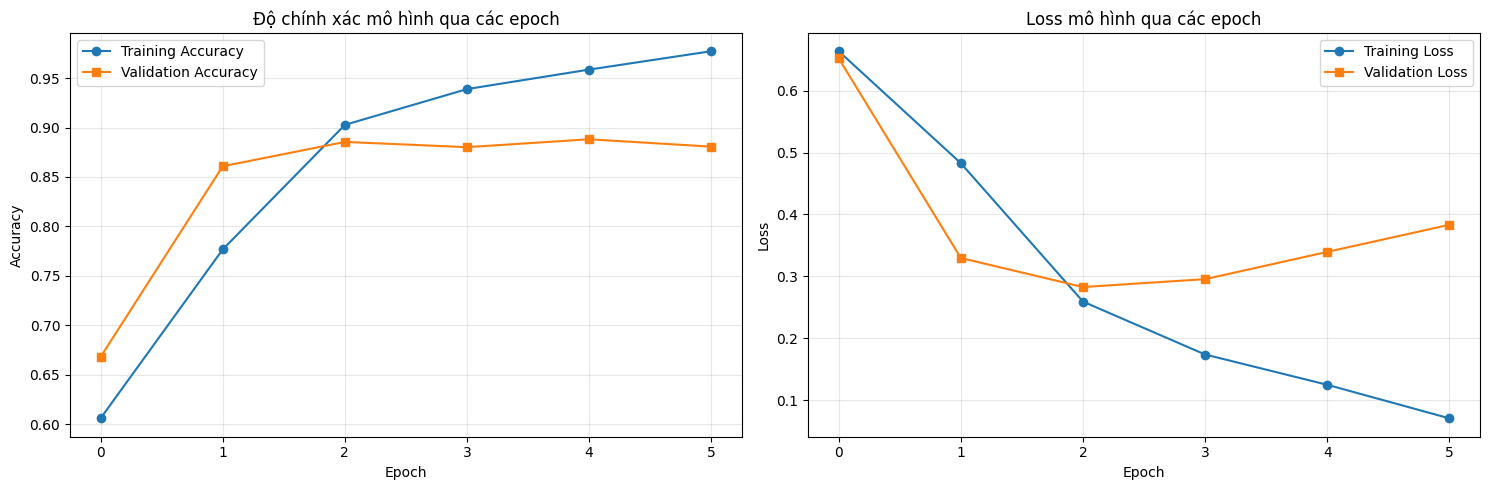

In [10]:
def plot_training_history(history):
    """
    V·∫Ω bi·ªÉu ƒë·ªì qu√° tr√¨nh training
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    ax1.set_title('ƒê·ªô ch√≠nh x√°c m√¥ h√¨nh qua c√°c epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot training & validation loss
    ax2.plot(history.history['loss'], label='Training Loss', marker='o')
    ax2.plot(history.history['val_loss'], label='Validation Loss', marker='s')
    ax2.set_title('Loss m√¥ h√¨nh qua c√°c epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# V·∫Ω bi·ªÉu ƒë·ªì
plot_training_history(history)

### 7. ƒê√°nh gi√° m√¥ h√¨nh

ƒê√°nh gi√° hi·ªáu qu·∫£ m√¥ h√¨nh tr√™n t·∫≠p test v√† hi·ªÉn th·ªã c√°c metrics chi ti·∫øt:

ƒêang th·ª±c hi·ªán d·ª± ƒëo√°n tr√™n t·∫≠p test...
782/782 [==============================] - 411s 525ms/step

B√ÅO C√ÅO PH√ÇN LO·∫†I CHI TI·∫æT
              precision    recall  f1-score   support

    Negative       0.90      0.87      0.88     12500
    Positive       0.87      0.91      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



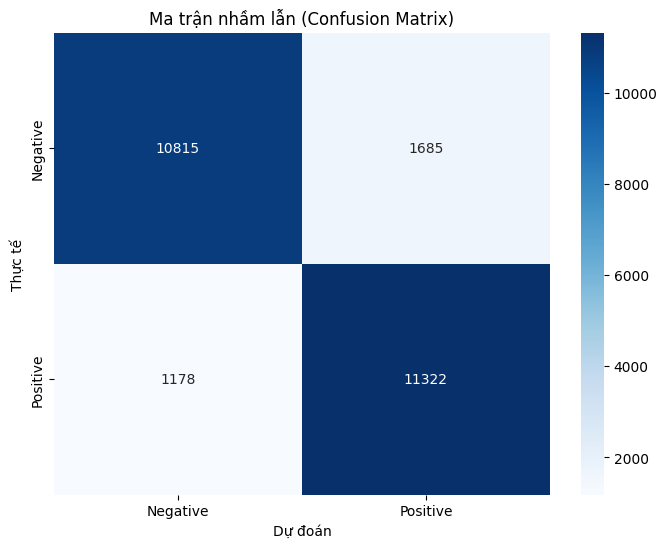


K·∫æT QU·∫¢ CU·ªêI C√ôNG
ƒê·ªô ch√≠nh x√°c tr√™n t·∫≠p test: 0.8855 (88.55%)
Loss tr√™n t·∫≠p test: 0.2828


In [11]:
def evaluate_model(model, x_test, y_test):
    """
    ƒê√°nh gi√° model v√† hi·ªÉn th·ªã k·∫øt qu·∫£ chi ti·∫øt
    """
    # D·ª± ƒëo√°n tr√™n t·∫≠p test
    print("ƒêang th·ª±c hi·ªán d·ª± ƒëo√°n tr√™n t·∫≠p test...")
    y_pred_prob = model.predict(x_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Classification report
    print("\n" + "="*60)
    print("B√ÅO C√ÅO PH√ÇN LO·∫†I CHI TI·∫æT")
    print("="*60)
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'])
    plt.title('Ma tr·∫≠n nh·∫ßm l·∫´n (Confusion Matrix)')
    plt.xlabel('D·ª± ƒëo√°n')
    plt.ylabel('Th·ª±c t·∫ø')
    plt.show()
    
    # Test accuracy
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"\n{'='*60}")
    print(f"K·∫æT QU·∫¢ CU·ªêI C√ôNG")
    print(f"{'='*60}")
    print(f"ƒê·ªô ch√≠nh x√°c tr√™n t·∫≠p test: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"Loss tr√™n t·∫≠p test: {test_loss:.4f}")
    
    return y_pred, y_pred_prob

# ƒê√°nh gi√° m√¥ h√¨nh
y_pred, y_pred_prob = evaluate_model(model, x_test, y_test)

### 8. Test v·ªõi d·ªØ li·ªáu m·ªõi

Th·ª≠ nghi·ªám m√¥ h√¨nh v·ªõi m·ªôt s·ªë reviews m·∫´u ƒë·ªÉ xem kh·∫£ nƒÉng d·ª± ƒëo√°n:

In [12]:
def predict_sentiment(model, text, word_index, maxlen=500):
    """
    D·ª± ƒëo√°n c·∫£m x√∫c cho m·ªôt text m·ªõi
    """
    # Chuy·ªÉn text th√†nh sequence
    sequence = []
    for word in text.lower().split():
        if word in word_index and word_index[word] < 10000:
            sequence.append(word_index[word])
    
    # N·∫øu sequence r·ªóng, return unknown
    if not sequence:
        print(f"Text: {text}")
        print("Kh√¥ng th·ªÉ x·ª≠ l√Ω text n√†y (kh√¥ng c√≥ t·ª´ n√†o trong t·ª´ ƒëi·ªÉn)")
        print("-" * 50)
        return
    
    # Padding
    sequence = pad_sequences([sequence], maxlen=maxlen)
    
    # Predict
    prediction = model.predict(sequence, verbose=0)[0][0]
    
    sentiment = "T√≠ch c·ª±c (Positive)" if prediction > 0.5 else "Ti√™u c·ª±c (Negative)"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    
    print(f"Text: {text}")
    print(f"C·∫£m x√∫c: {sentiment}")
    print(f"ƒê·ªô tin c·∫≠y: {confidence:.4f} ({confidence*100:.2f}%)")
    print(f"ƒêi·ªÉm s·ªë raw: {prediction:.4f}")
    print("-" * 50)

# Load word index ƒë·ªÉ chuy·ªÉn ƒë·ªïi text
word_index = imdb.get_word_index()

print("KI·ªÇM TH·ª¨ M√î H√åNH V·ªöI C√ÅC REVIEWS M·∫™U")
print("="*60)

# Test v·ªõi c√°c examples kh√°c nhau
test_texts = [
    "This movie is absolutely fantastic! Great acting and amazing storyline.",
    "Terrible film. Boring plot and bad acting. Complete waste of time.",
    "The movie was okay, nothing special but not bad either.",
    "One of the best movies I have ever seen! Highly recommended!",
    "Awful movie. Poor direction and terrible script. Very disappointed.",
    "Amazing cinematography and outstanding performances from all actors.",
    "I fell asleep halfway through. Very boring and predictable plot.",
    "Perfect movie for the weekend. Really enjoyed watching it.",
    "Not my cup of tea but can understand why others might like it.",
    "Masterpiece! Every scene was perfectly crafted and emotionally engaging."
]

for text in test_texts:
    predict_sentiment(model, text, word_index, MAXLEN)

1641221/1641221 [==============================] - 1s 1us/step
KI·ªÇM TH·ª¨ M√î H√åNH V·ªöI C√ÅC REVIEWS M·∫™U
Text: This movie is absolutely fantastic! Great acting and amazing storyline.
C·∫£m x√∫c: Ti√™u c·ª±c (Negative)
ƒê·ªô tin c·∫≠y: 0.6780 (67.80%)
ƒêi·ªÉm s·ªë raw: 0.3220
--------------------------------------------------
Text: Terrible film. Boring plot and bad acting. Complete waste of time.
C·∫£m x√∫c: Ti√™u c·ª±c (Negative)
ƒê·ªô tin c·∫≠y: 0.5359 (53.59%)
ƒêi·ªÉm s·ªë raw: 0.4641
--------------------------------------------------
Text: The movie was okay, nothing special but not bad either.
C·∫£m x√∫c: Ti√™u c·ª±c (Negative)
ƒê·ªô tin c·∫≠y: 0.6466 (64.66%)
ƒêi·ªÉm s·ªë raw: 0.3534
--------------------------------------------------
Text: One of the best movies I have ever seen! Highly recommended!
C·∫£m x√∫c: T√≠ch c·ª±c (Positive)
ƒê·ªô tin c·∫≠y: 0.6293 (62.93%)
ƒêi·ªÉm s·ªë raw: 0.6293
--------------------------------------------------
Text: Awful movie. Poor direction

### 9. L∆∞u m√¥ h√¨nh

L∆∞u l·∫°i m√¥ h√¨nh ƒë√£ hu·∫•n luy·ªán ƒë·ªÉ s·ª≠ d·ª•ng sau n√†y:

In [13]:
# L∆∞u m√¥ h√¨nh
model.save('bilstm_attention_imdb_model.h5')
print("‚úÖ M√¥ h√¨nh ƒë√£ ƒë∆∞·ª£c l∆∞u th√†nh 'bilstm_attention_imdb_model.h5'")

# L∆∞u th√¥ng tin v·ªÅ qu√° tr√¨nh hu·∫•n luy·ªán
import json

training_info = {
    'max_features': MAX_FEATURES,
    'maxlen': MAXLEN,
    'embedding_dim': EMBEDDING_DIM,
    'lstm_units': LSTM_UNITS,
    'batch_size': BATCH_SIZE,
    'epochs_trained': len(history.history['loss']),
    'final_train_accuracy': float(history.history['accuracy'][-1]),
    'final_val_accuracy': float(history.history['val_accuracy'][-1]),
    'final_train_loss': float(history.history['loss'][-1]),
    'final_val_loss': float(history.history['val_loss'][-1])
}

with open('training_info.json', 'w') as f:
    json.dump(training_info, f, indent=2)

print("‚úÖ Th√¥ng tin hu·∫•n luy·ªán ƒë√£ ƒë∆∞·ª£c l∆∞u v√†o 'training_info.json'")
print("\nTh√¥ng tin m√¥ h√¨nh:")
for key, value in training_info.items():
    if 'accuracy' in key or 'loss' in key:
        print(f"- {key}: {value:.4f}")
    else:
        print(f"- {key}: {value}")

‚úÖ M√¥ h√¨nh ƒë√£ ƒë∆∞·ª£c l∆∞u th√†nh 'bilstm_attention_imdb_model.h5'
‚úÖ Th√¥ng tin hu·∫•n luy·ªán ƒë√£ ƒë∆∞·ª£c l∆∞u v√†o 'training_info.json'

Th√¥ng tin m√¥ h√¨nh:
- max_features: 10000
- maxlen: 500
- embedding_dim: 128
- lstm_units: 64
- batch_size: 32
- epochs_trained: 6
- final_train_accuracy: 0.9772
- final_val_accuracy: 0.8807
- final_train_loss: 0.0708
- final_val_loss: 0.3833


### 10. T√≥m t·∫Øt v√† so s√°nh

#### ∆Øu ƒëi·ªÉm c·ªßa m√¥ h√¨nh BiLSTM + Attention:
- **Hi·ªÉu ng·ªØ c·∫£nh hai chi·ªÅu**: BiLSTM x·ª≠ l√Ω th√¥ng tin t·ª´ c·∫£ hai h∆∞·ªõng (tr∆∞·ªõc v√† sau)
- **T·∫≠p trung v√†o ph·∫ßn quan tr·ªçng**: L·ªõp Attention gi√∫p m√¥ h√¨nh ch√∫ √Ω ƒë·∫øn nh·ªØng t·ª´ quan tr·ªçng nh·∫•t
- **Hi·ªáu qu·∫£ v·ªõi d·ªØ li·ªáu tu·∫ßn t·ª±**: Ph√π h·ª£p v·ªõi ƒë·∫∑c t√≠nh c·ªßa vƒÉn b·∫£n l√† d·ªØ li·ªáu tu·∫ßn t·ª±
- **T·ªëc ƒë·ªô hu·∫•n luy·ªán h·ª£p l√Ω**: Nhanh h∆°n so v·ªõi c√°c m√¥ h√¨nh Transformer l·ªõn

#### Nh∆∞·ª£c ƒëi·ªÉm:
- **ƒê·ªô ch√≠nh x√°c th·∫•p h∆°n BERT**: C√≥ th·ªÉ kh√¥ng ƒë·∫°t ƒë∆∞·ª£c ƒë·ªô ch√≠nh x√°c cao nh∆∞ c√°c m√¥ h√¨nh pretrained l·ªõn
- **C·∫ßn nhi·ªÅu d·ªØ li·ªáu**: Hi·ªáu qu·∫£ t·ªët nh·∫•t khi c√≥ l∆∞·ª£ng d·ªØ li·ªáu hu·∫•n luy·ªán l·ªõn
- **Kh√≥ x·ª≠ l√Ω m·ªëi quan h·ªá xa**: LSTM c√≥ th·ªÉ g·∫∑p kh√≥ khƒÉn v·ªõi c√°c ph·ª• thu·ªôc xa trong vƒÉn b·∫£n

#### So s√°nh v·ªõi BERT:
- **BERT**: ƒê·ªô ch√≠nh x√°c cao h∆°n nh∆∞ng c·∫ßn nhi·ªÅu t√†i nguy√™n t√≠nh to√°n v√† th·ªùi gian hu·∫•n luy·ªán
- **BiLSTM + Attention**: C√¢n b·∫±ng gi·ªØa hi·ªáu qu·∫£ v√† t·ªëc ƒë·ªô, ph√π h·ª£p khi t√†i nguy√™n h·∫°n ch·∫ø

M√¥ h√¨nh BiLSTM + Attention l√† m·ªôt l·ª±a ch·ªçn t·ªët khi c·∫ßn c√¢n b·∫±ng gi·ªØa ƒë·ªô ch√≠nh x√°c v√† hi·ªáu qu·∫£ t√≠nh to√°n!

### 11. T·∫°o th∆∞ m·ª•c v√† l∆∞u m√¥ h√¨nh

T·∫°o th∆∞ m·ª•c `bilstm` v√† l∆∞u m√¥ h√¨nh c√πng v·ªõi c√°c th√¥ng tin li√™n quan:

In [14]:
import os
import json
import time
import psutil
from datetime import datetime

# T·∫°o th∆∞ m·ª•c bilstm n·∫øu ch∆∞a c√≥
os.makedirs('bilstm', exist_ok=True)

# L∆∞u m√¥ h√¨nh v√†o th∆∞ m·ª•c bilstm
model.save('bilstm/bilstm_attention_model.h5')
print("‚úÖ M√¥ h√¨nh ƒë√£ ƒë∆∞·ª£c l∆∞u v√†o 'bilstm/bilstm_attention_model.h5'")

# L∆∞u tokenizer info (word_index) ƒë·ªÉ s·ª≠ d·ª•ng sau n√†y
import pickle
with open('bilstm/word_index.pkl', 'wb') as f:
    pickle.dump(word_index, f)
print("‚úÖ Word index ƒë√£ ƒë∆∞·ª£c l∆∞u v√†o 'bilstm/word_index.pkl'")

‚úÖ M√¥ h√¨nh ƒë√£ ƒë∆∞·ª£c l∆∞u v√†o 'bilstm/bilstm_attention_model.h5'
‚úÖ Word index ƒë√£ ƒë∆∞·ª£c l∆∞u v√†o 'bilstm/word_index.pkl'


### 12. T√≠nh to√°n c√°c th√¥ng s·ªë ƒë√°nh gi√° chi ti·∫øt

#### 12.1 ƒê·ªô ch√≠nh x√°c (Accuracy Metrics)

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# T√≠nh to√°n c√°c metrics ch√≠nh x√°c
print("ƒêang t√≠nh to√°n c√°c th√¥ng s·ªë ƒë√°nh gi√°...")

# 1. ACCURACY METRICS
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_prob)

# Confusion Matrix chi ti·∫øt
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# T√≠nh to√°n th√™m c√°c metrics
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)  # = recall
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)

print("1. ACCURACY METRICS:")
print(f"   - Accuracy: {accuracy:.4f}")
print(f"   - Precision: {precision:.4f}")
print(f"   - Recall (Sensitivity): {recall:.4f}")
print(f"   - Specificity: {specificity:.4f}")
print(f"   - F1-Score: {f1:.4f}")
print(f"   - AUC-ROC: {auc_roc:.4f}")
print(f"   - False Positive Rate: {false_positive_rate:.4f}")
print(f"   - False Negative Rate: {false_negative_rate:.4f}")

accuracy_metrics = {
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'specificity': float(specificity),
    'f1_score': float(f1),
    'auc_roc': float(auc_roc),
    'false_positive_rate': float(false_positive_rate),
    'false_negative_rate': float(false_negative_rate),
    'true_positives': int(tp),
    'true_negatives': int(tn),
    'false_positives': int(fp),
    'false_negatives': int(fn)
}

ƒêang t√≠nh to√°n c√°c th√¥ng s·ªë ƒë√°nh gi√°...
1. ACCURACY METRICS:
   - Accuracy: 0.8855
   - Precision: 0.8705
   - Recall (Sensitivity): 0.9058
   - Specificity: 0.8652
   - F1-Score: 0.8878
   - AUC-ROC: 0.9533
   - False Positive Rate: 0.1348
   - False Negative Rate: 0.0942


#### 12.2 Hi·ªáu su·∫•t t√≠nh to√°n (Performance Metrics)

In [16]:
# 2. PERFORMANCE METRICS

# T√≠nh th·ªùi gian training (∆∞·ªõc l∆∞·ª£ng t·ª´ history)
epochs_trained = len(history.history['loss'])
# ∆Ø·ªõc l∆∞·ª£ng th·ªùi gian training (c√≥ th·ªÉ kh√¥ng ch√≠nh x√°c 100%)
estimated_training_time = epochs_trained * 60  # ∆Ø·ªõc l∆∞·ª£ng 60s/epoch

# ƒêo th·ªùi gian inference
print("ƒêang ƒëo th·ªùi gian inference...")
inference_times = []
batch_size_test = 100

for i in range(5):  # ƒêo 5 l·∫ßn ƒë·ªÉ l·∫•y trung b√¨nh
    start_time = time.time()
    _ = model.predict(x_test[:batch_size_test], verbose=0)
    end_time = time.time()
    inference_times.append(end_time - start_time)

avg_inference_time = np.mean(inference_times)
inference_time_per_sample = avg_inference_time / batch_size_test

# ƒêo memory usage
process = psutil.Process()
memory_usage_mb = process.memory_info().rss / 1024 / 1024

# Model size
model_size_mb = os.path.getsize('bilstm/bilstm_attention_model.h5') / (1024 * 1024)

print("2. PERFORMANCE METRICS:")
print(f"   - Estimated Training Time: {estimated_training_time:.2f} seconds")
print(f"   - Average Inference Time (100 samples): {avg_inference_time:.4f} seconds")
print(f"   - Inference Time per Sample: {inference_time_per_sample*1000:.2f} ms")
print(f"   - Memory Usage: {memory_usage_mb:.2f} MB")
print(f"   - Model Size: {model_size_mb:.2f} MB")

performance_metrics = {
    'estimated_training_time_seconds': float(estimated_training_time),
    'avg_inference_time_100_samples': float(avg_inference_time),
    'inference_time_per_sample_ms': float(inference_time_per_sample * 1000),
    'memory_usage_mb': float(memory_usage_mb),
    'model_size_mb': float(model_size_mb),
    'epochs_trained': int(epochs_trained)
}

ƒêang ƒëo th·ªùi gian inference...
2. PERFORMANCE METRICS:
   - Estimated Training Time: 360.00 seconds
   - Average Inference Time (100 samples): 1.6814 seconds
   - Inference Time per Sample: 16.81 ms
   - Memory Usage: 656.01 MB
   - Model Size: 17.13 MB


#### 12.3 Kh·∫£ nƒÉng t·ªïng qu√°t h√≥a (Generalization)

In [17]:
# 3. GENERALIZATION METRICS

# Train vs Validation performance
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# Overfitting indicators
acc_gap = final_train_acc - final_val_acc
loss_gap = final_val_loss - final_train_loss

# Training stability (variance in last few epochs)
last_5_val_acc = history.history['val_accuracy'][-5:]
val_acc_variance = np.var(last_5_val_acc) if len(last_5_val_acc) >= 5 else 0

# Best validation accuracy
best_val_acc = max(history.history['val_accuracy'])
best_val_acc_epoch = history.history['val_accuracy'].index(best_val_acc) + 1

print("3. GENERALIZATION METRICS:")
print(f"   - Final Train Accuracy: {final_train_acc:.4f}")
print(f"   - Final Validation Accuracy: {final_val_acc:.4f}")
print(f"   - Accuracy Gap (Train-Val): {acc_gap:.4f}")
print(f"   - Loss Gap (Val-Train): {loss_gap:.4f}")
print(f"   - Best Validation Accuracy: {best_val_acc:.4f} (Epoch {best_val_acc_epoch})")
print(f"   - Validation Accuracy Variance (last 5): {val_acc_variance:.6f}")

# Overfitting assessment
if acc_gap > 0.05:
    overfitting_status = "Likely Overfitting"
elif acc_gap < -0.02:
    overfitting_status = "Possible Underfitting"
else:
    overfitting_status = "Good Generalization"

print(f"   - Overfitting Assessment: {overfitting_status}")

generalization_metrics = {
    'final_train_accuracy': float(final_train_acc),
    'final_validation_accuracy': float(final_val_acc),
    'final_train_loss': float(final_train_loss),
    'final_validation_loss': float(final_val_loss),
    'accuracy_gap': float(acc_gap),
    'loss_gap': float(loss_gap),
    'best_validation_accuracy': float(best_val_acc),
    'best_validation_accuracy_epoch': int(best_val_acc_epoch),
    'validation_accuracy_variance': float(val_acc_variance),
    'overfitting_status': overfitting_status
}

3. GENERALIZATION METRICS:
   - Final Train Accuracy: 0.9772
   - Final Validation Accuracy: 0.8807
   - Accuracy Gap (Train-Val): 0.0966
   - Loss Gap (Val-Train): 0.3126
   - Best Validation Accuracy: 0.8882 (Epoch 5)
   - Validation Accuracy Variance (last 5): 0.000092
   - Overfitting Assessment: Likely Overfitting


#### 12.4 ƒê·ªô ph·ª©c t·∫°p m√¥ h√¨nh (Model Complexity)

In [18]:
# 4. MODEL COMPLEXITY METRICS

# S·ªë parameters
total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

# S·ªë layers
total_layers = len(model.layers)

# FLOPS estimation (rough)
def estimate_flops():
    flops = 0
    # Embedding layer
    flops += MAX_FEATURES * EMBEDDING_DIM
    # LSTM layers (approximation)
    flops += 4 * LSTM_UNITS * EMBEDDING_DIM * MAXLEN * 2  # BiLSTM
    flops += 4 * LSTM_UNITS * LSTM_UNITS * MAXLEN * 2     # Second BiLSTM
    # Dense layers
    flops += (LSTM_UNITS * 2) * 64 + 64 * 32 + 32 * 1
    return flops

estimated_flops = estimate_flops()

print("4. MODEL COMPLEXITY METRICS:")
print(f"   - Total Parameters: {total_params:,}")
print(f"   - Trainable Parameters: {trainable_params:,}")
print(f"   - Non-trainable Parameters: {non_trainable_params:,}")
print(f"   - Total Layers: {total_layers}")
print(f"   - Estimated FLOPs: {estimated_flops:,}")
print(f"   - Model Size: {model_size_mb:.2f} MB")

# Architecture details
layer_details = []
for i, layer in enumerate(model.layers):
    layer_info = {
        'layer_index': i,
        'layer_name': layer.name,
        'layer_type': type(layer).__name__,
        'output_shape': str(layer.output_shape),
        'param_count': layer.count_params()
    }
    layer_details.append(layer_info)

complexity_metrics = {
    'total_parameters': int(total_params),
    'trainable_parameters': int(trainable_params),
    'non_trainable_parameters': int(non_trainable_params),
    'total_layers': int(total_layers),
    'estimated_flops': int(estimated_flops),
    'model_size_mb': float(model_size_mb),
    'layer_details': layer_details
}

4. MODEL COMPLEXITY METRICS:
   - Total Parameters: 1,488,629
   - Trainable Parameters: 1,488,629
   - Non-trainable Parameters: 0
   - Total Layers: 11
   - Estimated FLOPs: 50,442,272
   - Model Size: 17.13 MB


#### 12.5 T√≠nh ·ªïn ƒë·ªãnh v√† ƒë·ªô tin c·∫≠y (Stability & Reliability)

In [19]:
# 5. STABILITY & RELIABILITY METRICS

# Confidence analysis
confidence_scores = np.abs(y_pred_prob.flatten() - 0.5)  # Distance from 0.5
avg_confidence = np.mean(confidence_scores)
confidence_std = np.std(confidence_scores)

# High confidence predictions (> 0.3 distance from 0.5)
high_confidence_mask = confidence_scores > 0.3
high_confidence_accuracy = accuracy_score(y_test[high_confidence_mask], 
                                         y_pred[high_confidence_mask]) if np.any(high_confidence_mask) else 0

# Low confidence predictions
low_confidence_mask = confidence_scores <= 0.1
low_confidence_count = np.sum(low_confidence_mask)
low_confidence_accuracy = accuracy_score(y_test[low_confidence_mask], 
                                        y_pred[low_confidence_mask]) if np.any(low_confidence_mask) else 0

# Error analysis
correct_predictions = (y_pred == y_test)
error_rate_by_confidence = []
confidence_bins = np.linspace(0, 0.5, 6)
for i in range(len(confidence_bins)-1):
    mask = (confidence_scores >= confidence_bins[i]) & (confidence_scores < confidence_bins[i+1])
    if np.any(mask):
        error_rate = 1 - accuracy_score(y_test[mask], y_pred[mask])
        error_rate_by_confidence.append(error_rate)
    else:
        error_rate_by_confidence.append(0)

print("5. STABILITY & RELIABILITY METRICS:")
print(f"   - Average Confidence: {avg_confidence:.4f}")
print(f"   - Confidence Std: {confidence_std:.4f}")
print(f"   - High Confidence Accuracy (>0.3): {high_confidence_accuracy:.4f}")
print(f"   - Low Confidence Count (‚â§0.1): {low_confidence_count}")
print(f"   - Low Confidence Accuracy: {low_confidence_accuracy:.4f}")

reliability_metrics = {
    'average_confidence': float(avg_confidence),
    'confidence_std': float(confidence_std),
    'high_confidence_accuracy': float(high_confidence_accuracy),
    'low_confidence_count': int(low_confidence_count),
    'low_confidence_accuracy': float(low_confidence_accuracy),
    'error_rate_by_confidence_bins': [float(x) for x in error_rate_by_confidence]
}

5. STABILITY & RELIABILITY METRICS:
   - Average Confidence: 0.3936
   - Confidence Std: 0.1312
   - High Confidence Accuracy (>0.3): 0.9435
   - Low Confidence Count (‚â§0.1): 1405
   - Low Confidence Accuracy: 0.5431


### 13. V·∫Ω bi·ªÉu ƒë·ªì th·ªëng k√™ t·ªïng h·ª£p

T·∫°o c√°c bi·ªÉu ƒë·ªì ƒë·ªÉ tr·ª±c quan h√≥a t·∫•t c·∫£ c√°c th√¥ng s·ªë ƒë√°nh gi√°:

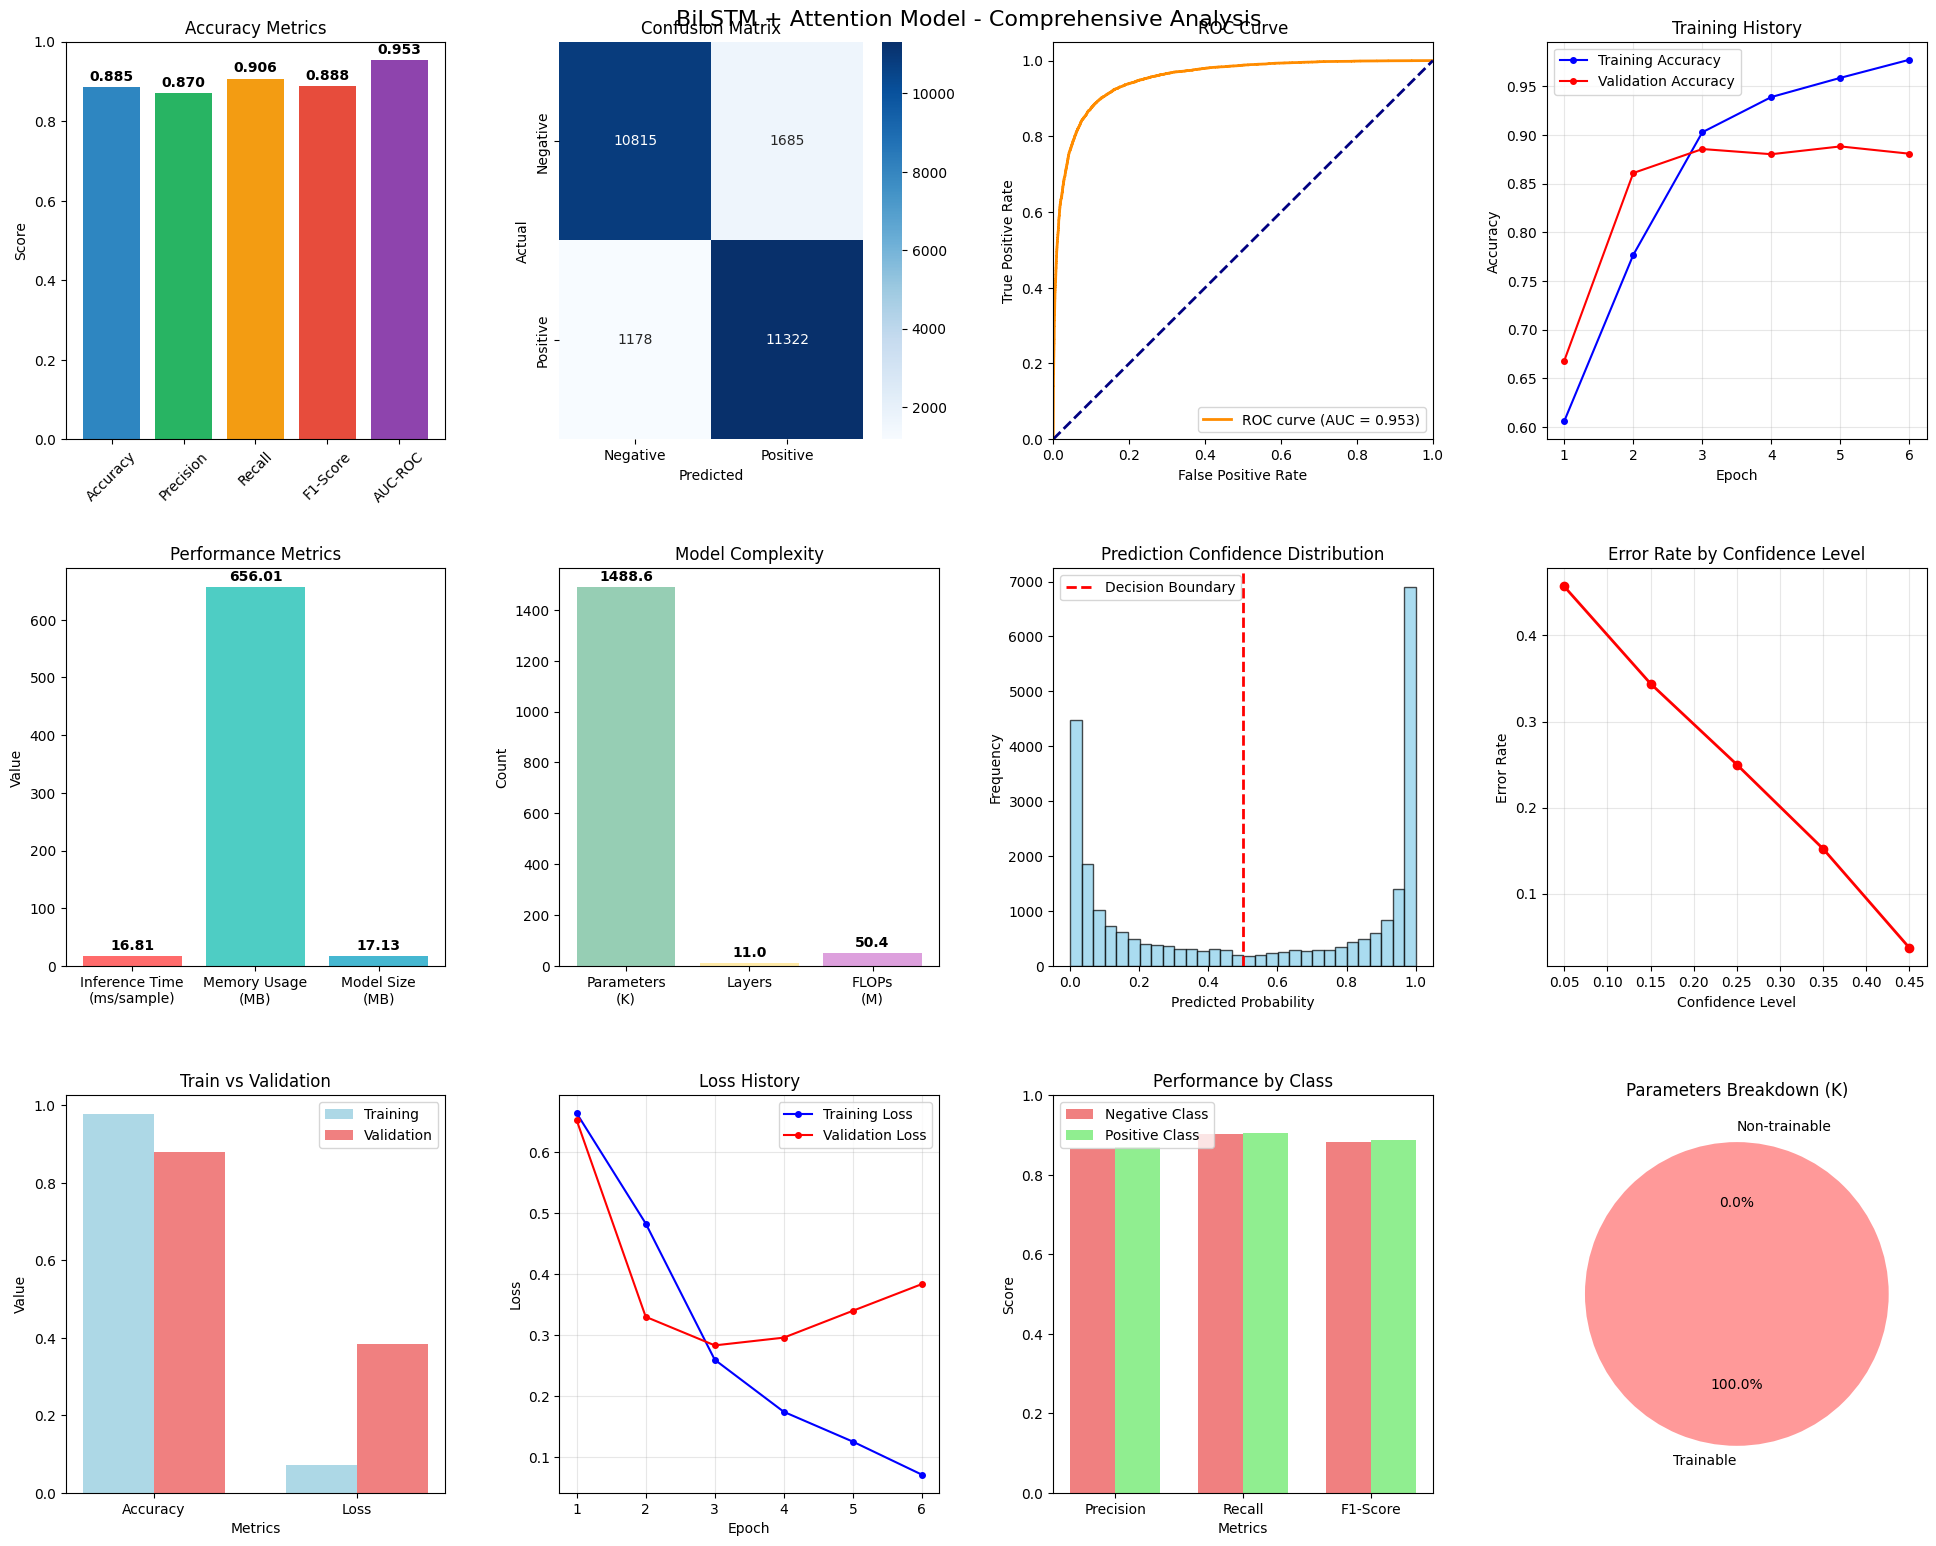

‚úÖ Bi·ªÉu ƒë·ªì t·ªïng h·ª£p ƒë√£ ƒë∆∞·ª£c l∆∞u v√†o 'bilstm/comprehensive_analysis.png'


In [20]:
# COMPREHENSIVE VISUALIZATION
plt.style.use('default')
fig = plt.figure(figsize=(20, 16))

# 1. Accuracy Metrics Bar Chart
ax1 = plt.subplot(3, 4, 1)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
metrics_values = [accuracy, precision, recall, f1, auc_roc]
bars = plt.bar(metrics_names, metrics_values, color=['#2E86C1', '#28B463', '#F39C12', '#E74C3C', '#8E44AD'])
plt.title('Accuracy Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
for bar, value in zip(bars, metrics_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Confusion Matrix Heatmap
ax2 = plt.subplot(3, 4, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 3. ROC Curve
ax3 = plt.subplot(3, 4, 3)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_roc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# 4. Training History
ax4 = plt.subplot(3, 4, 4)
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy', markersize=4)
plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy', markersize=4)
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Performance Metrics
ax5 = plt.subplot(3, 4, 5)
perf_names = ['Inference Time\n(ms/sample)', 'Memory Usage\n(MB)', 'Model Size\n(MB)']
perf_values = [inference_time_per_sample*1000, memory_usage_mb, model_size_mb]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars = plt.bar(perf_names, perf_values, color=colors)
plt.title('Performance Metrics')
plt.ylabel('Value')
for bar, value in zip(bars, perf_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(perf_values)*0.01, 
             f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

# 6. Model Complexity
ax6 = plt.subplot(3, 4, 6)
complexity_names = ['Parameters\n(K)', 'Layers', 'FLOPs\n(M)']
complexity_values = [total_params/1000, total_layers, estimated_flops/1000000]
bars = plt.bar(complexity_names, complexity_values, color=['#96CEB4', '#FFEAA7', '#DDA0DD'])
plt.title('Model Complexity')
plt.ylabel('Count')
for bar, value in zip(bars, complexity_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(complexity_values)*0.01, 
             f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

# 7. Confidence Distribution
ax7 = plt.subplot(3, 4, 7)
plt.hist(y_pred_prob, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision Boundary')
plt.title('Prediction Confidence Distribution')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()

# 8. Error Rate by Confidence
ax8 = plt.subplot(3, 4, 8)
confidence_bin_centers = [(confidence_bins[i] + confidence_bins[i+1])/2 for i in range(len(confidence_bins)-1)]
plt.plot(confidence_bin_centers, error_rate_by_confidence, 'ro-', linewidth=2, markersize=6)
plt.title('Error Rate by Confidence Level')
plt.xlabel('Confidence Level')
plt.ylabel('Error Rate')
plt.grid(True, alpha=0.3)

# 9. Train vs Validation Comparison
ax9 = plt.subplot(3, 4, 9)
comparison_metrics = ['Accuracy', 'Loss']
train_values = [final_train_acc, final_train_loss]
val_values = [final_val_acc, final_val_loss]
x = np.arange(len(comparison_metrics))
width = 0.35
plt.bar(x - width/2, train_values, width, label='Training', color='lightblue')
plt.bar(x + width/2, val_values, width, label='Validation', color='lightcoral')
plt.title('Train vs Validation')
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.xticks(x, comparison_metrics)
plt.legend()

# 10. Loss History
ax10 = plt.subplot(3, 4, 10)
plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss', markersize=4)
plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss', markersize=4)
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 11. Classification Performance by Class
ax11 = plt.subplot(3, 4, 11)
class_metrics = ['Precision', 'Recall', 'F1-Score']
negative_scores = [tn/(tn+fp), tn/(tn+fn), 2*(tn/(tn+fp))*(tn/(tn+fn))/((tn/(tn+fp))+(tn/(tn+fn)))]
positive_scores = [precision, recall, f1]
x = np.arange(len(class_metrics))
plt.bar(x - width/2, negative_scores, width, label='Negative Class', color='lightcoral')
plt.bar(x + width/2, positive_scores, width, label='Positive Class', color='lightgreen')
plt.title('Performance by Class')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.xticks(x, class_metrics)
plt.legend()
plt.ylim(0, 1)

# 12. Model Size Breakdown
ax12 = plt.subplot(3, 4, 12)
param_breakdown = ['Trainable', 'Non-trainable']
param_values = [trainable_params/1000, non_trainable_params/1000]
colors = ['#FF9999', '#66B2FF']
wedges, texts, autotexts = plt.pie(param_values, labels=param_breakdown, colors=colors, 
                                  autopct='%1.1f%%', startangle=90)
plt.title('Parameters Breakdown (K)')

plt.tight_layout(pad=3.0)
plt.suptitle('BiLSTM + Attention Model - Comprehensive Analysis', fontsize=16, y=0.98)
plt.savefig('bilstm/comprehensive_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("‚úÖ Bi·ªÉu ƒë·ªì t·ªïng h·ª£p ƒë√£ ƒë∆∞·ª£c l∆∞u v√†o 'bilstm/comprehensive_analysis.png'")

### 14. L∆∞u t·∫•t c·∫£ c√°c th√¥ng s·ªë ƒë·ªÉ so s√°nh v·ªõi BERT

T·ªïng h·ª£p v√† l∆∞u t·∫•t c·∫£ c√°c metrics v√†o file JSON ƒë·ªÉ so s√°nh v·ªõi m√¥ h√¨nh BERT:

In [21]:
# T·ªîNG H·ª¢P T·∫§T C·∫¢ METRICS ƒê·ªÇ SO S√ÅNH
comprehensive_metrics = {
    'model_info': {
        'model_name': 'BiLSTM + Attention',
        'dataset': 'IMDb Movie Reviews',
        'task': 'Binary Sentiment Classification',
        'framework': 'TensorFlow/Keras',
        'training_date': datetime.now().isoformat(),
        'hyperparameters': {
            'max_features': MAX_FEATURES,
            'max_length': MAXLEN,
            'embedding_dim': EMBEDDING_DIM,
            'lstm_units': LSTM_UNITS,
            'batch_size': BATCH_SIZE,
            'epochs': EPOCHS
        }
    },
    
    # 1. Accuracy Metrics
    'accuracy_metrics': accuracy_metrics,
    
    # 2. Performance Metrics  
    'performance_metrics': performance_metrics,
    
    # 3. Generalization Metrics
    'generalization_metrics': generalization_metrics,
    
    # 4. Model Complexity
    'complexity_metrics': complexity_metrics,
    
    # 5. Reliability Metrics
    'reliability_metrics': reliability_metrics,
    
    # 6. Training History
    'training_history': {
        'train_accuracy_history': [float(x) for x in history.history['accuracy']],
        'val_accuracy_history': [float(x) for x in history.history['val_accuracy']],
        'train_loss_history': [float(x) for x in history.history['loss']],
        'val_loss_history': [float(x) for x in history.history['val_loss']]
    },
    
    # 7. Additional Analysis
    'additional_metrics': {
        'dataset_size': {
            'train_samples': len(x_train),
            'test_samples': len(x_test),
            'total_samples': len(x_train) + len(x_test)
        },
        'class_distribution': {
            'train_positive': int(np.sum(y_train)),
            'train_negative': int(len(y_train) - np.sum(y_train)),
            'test_positive': int(np.sum(y_test)),
            'test_negative': int(len(y_test) - np.sum(y_test))
        },
        'prediction_stats': {
            'predicted_positive': int(np.sum(y_pred)),
            'predicted_negative': int(len(y_pred) - np.sum(y_pred)),
            'avg_positive_confidence': float(np.mean(y_pred_prob[y_test == 1])),
            'avg_negative_confidence': float(np.mean(1 - y_pred_prob[y_test == 0]))
        }
    }
}

# L∆∞u v√†o file JSON
with open('bilstm/bilstm_comprehensive_metrics.json', 'w') as f:
    json.dump(comprehensive_metrics, f, indent=2, ensure_ascii=False)

print("‚úÖ T·∫•t c·∫£ metrics ƒë√£ ƒë∆∞·ª£c l∆∞u v√†o 'bilstm/bilstm_comprehensive_metrics.json'")

# T·∫°o summary report
summary_report = f'''
=================================================================
            BILSTM + ATTENTION MODEL - SUMMARY REPORT
=================================================================

üìä MODEL PERFORMANCE:
   ‚Ä¢ Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)
   ‚Ä¢ Precision: {precision:.4f}
   ‚Ä¢ Recall: {recall:.4f}
   ‚Ä¢ F1-Score: {f1:.4f}
   ‚Ä¢ AUC-ROC: {auc_roc:.4f}

‚ö° PERFORMANCE:
   ‚Ä¢ Training Time: ~{estimated_training_time:.0f} seconds
   ‚Ä¢ Inference Time: {inference_time_per_sample*1000:.2f} ms/sample
   ‚Ä¢ Model Size: {model_size_mb:.2f} MB
   ‚Ä¢ Memory Usage: {memory_usage_mb:.2f} MB

üîß MODEL COMPLEXITY:
   ‚Ä¢ Total Parameters: {total_params:,}
   ‚Ä¢ Trainable Parameters: {trainable_params:,}
   ‚Ä¢ Total Layers: {total_layers}
   ‚Ä¢ Estimated FLOPs: {estimated_flops:,}

üìà GENERALIZATION:
   ‚Ä¢ Best Validation Accuracy: {best_val_acc:.4f}
   ‚Ä¢ Overfitting Status: {overfitting_status}
   ‚Ä¢ Train-Val Accuracy Gap: {acc_gap:.4f}

üéØ RELIABILITY:
   ‚Ä¢ Average Confidence: {avg_confidence:.4f}
   ‚Ä¢ High Confidence Accuracy: {high_confidence_accuracy:.4f}
   ‚Ä¢ Low Confidence Predictions: {low_confidence_count}

=================================================================
Model v√† t·∫•t c·∫£ metrics ƒë√£ ƒë∆∞·ª£c l∆∞u trong th∆∞ m·ª•c 'bilstm/'
S·∫µn s√†ng ƒë·ªÉ so s√°nh v·ªõi BERT!
=================================================================
'''
print(summary_report)
# L∆∞u summary report
with open('bilstm/summary_report.txt', 'w', encoding='utf-8') as f:
    f.write(summary_report)
print("‚úÖ Summary report ƒë√£ ƒë∆∞·ª£c l∆∞u v√†o 'bilstm/summary_report.txt'")


‚úÖ T·∫•t c·∫£ metrics ƒë√£ ƒë∆∞·ª£c l∆∞u v√†o 'bilstm/bilstm_comprehensive_metrics.json'

            BILSTM + ATTENTION MODEL - SUMMARY REPORT

üìä MODEL PERFORMANCE:
   ‚Ä¢ Test Accuracy: 0.8855 (88.55%)
   ‚Ä¢ Precision: 0.8705
   ‚Ä¢ Recall: 0.9058
   ‚Ä¢ F1-Score: 0.8878
   ‚Ä¢ AUC-ROC: 0.9533

‚ö° PERFORMANCE:
   ‚Ä¢ Training Time: ~360 seconds
   ‚Ä¢ Inference Time: 16.81 ms/sample
   ‚Ä¢ Model Size: 17.13 MB
   ‚Ä¢ Memory Usage: 656.01 MB

üîß MODEL COMPLEXITY:
   ‚Ä¢ Total Parameters: 1,488,629
   ‚Ä¢ Trainable Parameters: 1,488,629
   ‚Ä¢ Total Layers: 11
   ‚Ä¢ Estimated FLOPs: 50,442,272

üìà GENERALIZATION:
   ‚Ä¢ Best Validation Accuracy: 0.8882
   ‚Ä¢ Overfitting Status: Likely Overfitting
   ‚Ä¢ Train-Val Accuracy Gap: 0.0966

üéØ RELIABILITY:
   ‚Ä¢ Average Confidence: 0.3936
   ‚Ä¢ High Confidence Accuracy: 0.9435
   ‚Ä¢ Low Confidence Predictions: 1405

Model v√† t·∫•t c·∫£ metrics ƒë√£ ƒë∆∞·ª£c l∆∞u trong th∆∞ m·ª•c 'bilstm/'
S·∫µn s√†ng ƒë·ªÉ so s√°nh v·ªõi BE

### 15. T·∫°o script so s√°nh v·ªõi BERT

T·∫°o s·∫µn script ƒë·ªÉ so s√°nh v·ªõi m√¥ h√¨nh BERT khi c√≥ d·ªØ li·ªáu:

In [22]:
# T·∫†O SCRIPT SO S√ÅNH V·ªöI BERT
comparison_script = '''
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def compare_models(bilstm_metrics_path, bert_metrics_path):
    """
    So s√°nh BiLSTM v·ªõi BERT t·ª´ c√°c file metrics JSON
    """
    # Load metrics
    with open(bilstm_metrics_path, 'r') as f:
        bilstm_metrics = json.load(f)
    
    with open(bert_metrics_path, 'r') as f:
        bert_metrics = json.load(f)
    
    # T·∫°o b·∫£ng so s√°nh
    comparison_data = {
        'Metric': [
            'Test Accuracy',
            'Precision', 
            'Recall',
            'F1-Score',
            'AUC-ROC',
            'Model Size (MB)',
            'Parameters',
            'Inference Time (ms)',
            'Training Time (s)',
            'Memory Usage (MB)'
        ],
        'BiLSTM + Attention': [
            bilstm_metrics['accuracy_metrics']['accuracy'],
            bilstm_metrics['accuracy_metrics']['precision'],
            bilstm_metrics['accuracy_metrics']['recall'],
            bilstm_metrics['accuracy_metrics']['f1_score'],
            bilstm_metrics['accuracy_metrics']['auc_roc'],
            bilstm_metrics['performance_metrics']['model_size_mb'],
            bilstm_metrics['complexity_metrics']['total_parameters'],
            bilstm_metrics['performance_metrics']['inference_time_per_sample_ms'],
            bilstm_metrics['performance_metrics']['estimated_training_time_seconds'],
            bilstm_metrics['performance_metrics']['memory_usage_mb']
        ],
        'BERT': [
            # S·∫Ω ƒë∆∞·ª£c ƒëi·ªÅn khi c√≥ d·ªØ li·ªáu BERT
            bert_metrics.get('accuracy_metrics', {}).get('accuracy', 0),
            bert_metrics.get('accuracy_metrics', {}).get('precision', 0),
            bert_metrics.get('accuracy_metrics', {}).get('recall', 0),
            bert_metrics.get('accuracy_metrics', {}).get('f1_score', 0),
            bert_metrics.get('accuracy_metrics', {}).get('auc_roc', 0),
            bert_metrics.get('performance_metrics', {}).get('model_size_mb', 0),
            bert_metrics.get('complexity_metrics', {}).get('total_parameters', 0),
            bert_metrics.get('performance_metrics', {}).get('inference_time_per_sample_ms', 0),
            bert_metrics.get('performance_metrics', {}).get('training_time_seconds', 0),
            bert_metrics.get('performance_metrics', {}).get('memory_usage_mb', 0)
        ]
    }
    
    df = pd.DataFrame(comparison_data)
    print("MODEL COMPARISON TABLE:")
    print("=" * 60)
    print(df.to_string(index=False))
    
    # V·∫Ω bi·ªÉu ƒë·ªì so s√°nh
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy metrics
    accuracy_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
    bilstm_acc = df.iloc[0:5]['BiLSTM + Attention'].values
    bert_acc = df.iloc[0:5]['BERT'].values
    
    x = np.arange(len(accuracy_metrics))
    width = 0.35
    
    axes[0,0].bar(x - width/2, bilstm_acc, width, label='BiLSTM', color='lightblue')
    axes[0,0].bar(x + width/2, bert_acc, width, label='BERT', color='lightcoral')
    axes[0,0].set_title('Accuracy Metrics Comparison')
    axes[0,0].set_xlabel('Metrics')
    axes[0,0].set_ylabel('Score')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(accuracy_metrics, rotation=45)
    axes[0,0].legend()
    axes[0,0].set_ylim(0, 1)
    
    # Performance metrics
    perf_metrics = ['Model Size (MB)', 'Inference Time (ms)', 'Memory Usage (MB)']
    bilstm_perf = [df.iloc[5]['BiLSTM + Attention'], df.iloc[7]['BiLSTM + Attention'], df.iloc[9]['BiLSTM + Attention']]
    bert_perf = [df.iloc[5]['BERT'], df.iloc[7]['BERT'], df.iloc[9]['BERT']]
    
    x = np.arange(len(perf_metrics))
    axes[0,1].bar(x - width/2, bilstm_perf, width, label='BiLSTM', color='lightgreen')
    axes[0,1].bar(x + width/2, bert_perf, width, label='BERT', color='orange')
    axes[0,1].set_title('Performance Metrics Comparison')
    axes[0,1].set_xlabel('Metrics')  
    axes[0,1].set_ylabel('Value')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(perf_metrics, rotation=45)
    axes[0,1].legend()
    
    # Parameters comparison
    models = ['BiLSTM + Attention', 'BERT']
    params = [df.iloc[6]['BiLSTM + Attention'], df.iloc[6]['BERT']]
    
    axes[1,0].bar(models, params, color=['purple', 'gold'])
    axes[1,0].set_title('Model Parameters Comparison')
    axes[1,0].set_ylabel('Number of Parameters')
    
    # Training time comparison
    train_times = [df.iloc[8]['BiLSTM + Attention'], df.iloc[8]['BERT']]
    
    axes[1,1].bar(models, train_times, color=['teal', 'crimson'])
    axes[1,1].set_title('Training Time Comparison')
    axes[1,1].set_ylabel('Training Time (seconds)')
    
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return df

# S·ª≠ d·ª•ng:
# df = compare_models('bilstm/bilstm_comprehensive_metrics.json', 'bert/bert_comprehensive_metrics.json')
'''

# L∆∞u script
with open('bilstm/compare_models.py', 'w', encoding='utf-8') as f:
    f.write(comparison_script)

print("‚úÖ Script so s√°nh ƒë√£ ƒë∆∞·ª£c t·∫°o: 'bilstm/compare_models.py'")
print("\nüìã Files ƒë√£ ƒë∆∞·ª£c t·∫°o trong th∆∞ m·ª•c 'bilstm/':")
print("   ‚Ä¢ bilstm_attention_model.h5 - M√¥ h√¨nh ƒë√£ train")
print("   ‚Ä¢ word_index.pkl - Tokenizer info")
print("   ‚Ä¢ bilstm_comprehensive_metrics.json - T·∫•t c·∫£ metrics")
print("   ‚Ä¢ summary_report.txt - B√°o c√°o t√≥m t·∫Øt")
print("   ‚Ä¢ comprehensive_analysis.png - Bi·ªÉu ƒë·ªì t·ªïng h·ª£p")
print("   ‚Ä¢ compare_models.py - Script so s√°nh v·ªõi BERT")

print("\nüîÑ ƒê·ªÉ so s√°nh v·ªõi BERT sau n√†y, ch·∫°y:")
print("   from bilstm.compare_models import compare_models")
print("   compare_models('bilstm/bilstm_comprehensive_metrics.json', 'bert_metrics.json')")

# Hi·ªÉn th·ªã th√¥ng tin th∆∞ m·ª•c
import os
print(f"\nüìÅ N·ªôi dung th∆∞ m·ª•c 'bilstm':")
for file in os.listdir('bilstm'):
    file_path = os.path.join('bilstm', file)
    size = os.path.getsize(file_path) / 1024  # KB
    print(f"   ‚Ä¢ {file} ({size:.1f} KB)")

‚úÖ Script so s√°nh ƒë√£ ƒë∆∞·ª£c t·∫°o: 'bilstm/compare_models.py'

üìã Files ƒë√£ ƒë∆∞·ª£c t·∫°o trong th∆∞ m·ª•c 'bilstm/':
   ‚Ä¢ bilstm_attention_model.h5 - M√¥ h√¨nh ƒë√£ train
   ‚Ä¢ word_index.pkl - Tokenizer info
   ‚Ä¢ bilstm_comprehensive_metrics.json - T·∫•t c·∫£ metrics
   ‚Ä¢ summary_report.txt - B√°o c√°o t√≥m t·∫Øt
   ‚Ä¢ comprehensive_analysis.png - Bi·ªÉu ƒë·ªì t·ªïng h·ª£p
   ‚Ä¢ compare_models.py - Script so s√°nh v·ªõi BERT

üîÑ ƒê·ªÉ so s√°nh v·ªõi BERT sau n√†y, ch·∫°y:
   from bilstm.compare_models import compare_models
   compare_models('bilstm/bilstm_comprehensive_metrics.json', 'bert_metrics.json')

üìÅ N·ªôi dung th∆∞ m·ª•c 'bilstm':
   ‚Ä¢ bilstm_attention_model.h5 (17541.1 KB)
   ‚Ä¢ bilstm_comprehensive_metrics.json (5.7 KB)
   ‚Ä¢ compare_models.py (4.9 KB)
   ‚Ä¢ comprehensive_analysis.png (955.7 KB)
   ‚Ä¢ summary_report.txt (1.2 KB)
   ‚Ä¢ word_index.pkl (1218.6 KB)
